In [2]:
######################
##	Library Imports
######################
%matplotlib inline
import matplotlib as mpl
# mpl.use('TkAgg') # Use this backend for displaying plots in window
# mpl.use('Agg') # Use this backend for writing plots to file

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize']    = [16, 9]
# mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex']       = True
mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.size']         = 22
mpl.rcParams['font.serif']        = 'Computer Modern Roman'
mpl.rcParams['lines.linewidth']   = 1.25
mpl.rcParams['lines.markersize']  = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import multiprocessing as mprocs
from threading import Thread
from subprocess import Popen, PIPE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
from scipy.linalg import subspace_angles
np.set_printoptions(threshold=sys.maxsize)
from numba import njit, jit, prange
import scipy.stats
import itertools

mpl.get_backend()

'module://ipykernel.pylab.backend_inline'

In [203]:
def open_file(N, k0, a, beta, u0, iters, m_end, m_iter, trans, numLEs, func_type):
    
    HDFfileData = -1
    dof = int(N /2 - k0)
    
    ## Check if file exists and open
    if numLEs == 1:
        ## Create filename from data
        filename = input_dir + "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]/LCEData_ITERS[{},{},{}]".format(N, k0, a, beta, u0, iters, m_end, m_iter)

        ## Check if file exists and open
        if os.path.exists(filename + "_TRANS[{}]_LEs[{}].h5".format(trans, numLEs)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]_LEs[{}].h5".format(trans, numLEs), 'r')
        elif os.path.exists(filename + "_TRANS[{}]_LEs[{}].h5".format(trans * 10, numLEs)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]_LEs[{}].h5".format(trans * 10, numLEs), 'r')
        elif os.path.exists(filename + "_TRANS[{}]_LEs[{}].h5".format(trans * 100, numLEs)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]_LEs[{}].h5".format(trans * 100, numLEs), 'r')
        elif os.path.exists(filename + "_TRANS[{}]_LEs[{}].h5".format(trans / 100, numLEs)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]_LEs[{}].h5".format(trans, numLEs), 'r')
        else: 
            print("File doesn't exist, check parameters!")
#             sys.exit()		
    else:
        ## Create filename from data
        filename = input_dir + "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]/CLVData_ITERS[{},{},{}]".format(N, k0, a, beta, u0, iters, m_end, m_iter)

        if os.path.exists(filename + "_TRANS[{}].h5".format(trans)):
            HDFfileData = h5py.File(filename + "_TRANS[{}].h5".format(trans), 'r')
        elif os.path.exists(filename + "_TRANS[{}].h5".format(trans * 10)):
            HDFfileData = h5py.File(filename + "_TRANS[{}].h5".format(trans * 10), 'r')
        elif os.path.exists(filename + "_TRANS[{}].h5".format(trans / 10)):
            HDFfileData = h5py.File(filename + "_TRANS[{}].h5".format(trans / 10), 'r')
        elif os.path.exists(filename + "_TRANS[{}].h5".format(trans * 100)):
            HDFfileData = h5py.File(filename + "_TRANS[{}].h5".format(trans * 100), 'r')
        elif os.path.exists(filename + "_TRANS[{}]".format(trans) + "_LEs[{}].h5".format(dof)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]".format(trans) + "_LEs[{}].h5".format(dof), 'r')
        elif os.path.exists(filename + "_TRANS[{}]".format(trans * 10) + "_LEs[{}].h5".format(dof)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]".format(trans * 10) + "_LEs[{}].h5".format(dof), 'r')
        elif os.path.exists(filename + "_TRANS[{}]".format(trans / 10) + "_LEs[{}].h5".format(dof)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]".format(trans / 10) + "_LEs[{}].h5".format(dof), 'r')
        elif os.path.exists(filename + "_TRANS[{}]".format(trans * 100) + "_LEs[{}].h5".format(dof)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]".format(trans * 100) + "_LEs[{}].h5".format(dof), 'r')
        elif os.path.exists(filename + "_TRANS[{}]".format(trans * 1000) + "_LEs[{}].h5".format(dof)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]".format(trans * 1000) + "_LEs[{}].h5".format(dof), 'r')
        else: 
            print("File doesn't exist, check parameters!")
#             sys.exit()



    return HDFfileData

In [204]:
@njit
def compute_entropy(clv, dof):

    H = 0.0

    for i in range(dof):
        H += clv[i] * np.log(clv[i])

    return -H 

@njit
def compute_centroid(clv, dof, kmin):

    C = 0.0

    for i in range(dof):
        C += clv[i] * (i + kmin)

    return C 

@njit
def compute_std(clv, cent, dof, kmin):

    std = 0.0
    
    for i in range(dof):
        std += (((i + kmin) - cent) ** 2) * clv[i]

    return np.sqrt(std)

@njit
def compute_chaotic_centroid(clv, dof, kmin, num_vecs):

    C = 0.0
    
    for n in range(num_vecs):
        for i in range(dof):
            C += clv[i, n] * (i + kmin)

    return C / num_vecs

@njit
def compute_cumulative(data, ):
    c = np.zeros(data.shape[0])
    
    for i in range(data.shape[0]):
        for j in range(i):
            c[i] += data[j]
            
    return c

In [205]:
@njit
def compute_zdata(clv, a_k, num_tsteps, dof, numLEs):
    
    z_data       = np.zeros((dof, dof))
    z_data_proj  = np.zeros((dof, dof))
    z_data_wnorm = np.zeros((dof, dof))
    v            = np.zeros((num_tsteps, dof, dof))
    v_wnorm      = np.zeros((num_tsteps, dof, dof))

    K           = np.arange(2.0, float(dof + 2), 1.0)
    K_norm_sqr  = np.linalg.norm(K) ** 2
    K_wnorm_sqr = np.linalg.norm(K * a_k[2:]) ** 2
    
    for t in range(num_tsteps):
        for j in range(numLEs):
            z_data[:, j] += np.square(clv[t, :, j])

            v[t, :, j]       = clv[t, :, j] - (K * (np.dot(clv[t, :, j], K))) / (K_norm_sqr)
            v_wnorm[t, :, j] = (clv[t, :, j] * a_k[2:]) - ((K * a_k[2:]) * (np.dot(clv[t, :, j] * a_k[2:], K * a_k[2:]))) / (K_wnorm_sqr)
            
            v[t, :, j]       = v[t, :, j] / np.linalg.norm(v[t, :, j])
            v_wnorm[t, :, j] = v_wnorm[t, :, j] / np.linalg.norm(v_wnorm[t, :, j])
            
            z_data_proj[:, j]  += np.square(v[t, :, j])
            z_data_wnorm[:, j] += np.square(v_wnorm[t, :, j])
    
    z_data       = z_data / num_tsteps
    z_data_proj  = z_data_proj / num_tsteps
    z_data_wnorm = z_data_wnorm / num_tsteps
    

    return z_data, z_data_proj, z_data_wnorm

In [206]:
N     = [128, 256, 512, 1024]
# N = [128]
# alpha = np.array([1.5])
alpha = np.arange(0.0, 2.55, 0.05)

k0    = 1
beta  = 0.0
iters = 400000
m_end = 8000
m_itr = 50
trans = 0
u0    = "RANDOM"

input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS"
output_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/Paper"


deg_of_freedom  = np.zeros((len(N)))
kurtosis        = np.zeros((len(N), len(alpha)))
skewness        = np.zeros((len(N), len(alpha)))
kaplan_york_dim = np.zeros((len(N), len(alpha)))
max_entropy     = np.zeros((len(N), len(alpha)))
pos_centroid         = np.zeros((len(N), len(alpha)))
pos_centroid_proj    = np.zeros((len(N), len(alpha)))
pos_centroid_wnorm   = np.zeros((len(N), len(alpha)))
max_entropy_proj     = np.zeros((len(N), len(alpha)))
max_entropy_wnorm    = np.zeros((len(N), len(alpha)))
max_centroid         = np.zeros((len(N), len(alpha)))
max_centroid_proj    = np.zeros((len(N), len(alpha)))
max_centroid_wnorm   = np.zeros((len(N), len(alpha)))

var_centroid         = np.zeros((len(N), len(alpha)))
var_centroid_proj    = np.zeros((len(N), len(alpha)))
var_centroid_wnorm   = np.zeros((len(N), len(alpha)))



quartile = np.zeros((2, len(N), len(alpha)))

k_ind  = np.zeros((len(N), len(alpha)))
k_ratio = np.zeros((len(N), len(alpha)))

In [207]:
for i, n in enumerate(N):
    
    spectra = np.zeros((len(alpha), int(n / 2 - k0)))
    deg_of_freedom[i] = n / 2 - k0
    
    for j, a in enumerate(alpha):
        
        ## ------- Opend file
        filename = input_dir + "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]/LCEData_ITERS[{}]".format(n, k0, a, beta, u0, iters)
        HDFfileData = h5py.File(filename + "_TRANS[{}].h5".format(trans), 'r')
        
        ## ------- Read in Data
        lce = HDFfileData['LCE'][:, :]
#         amps    = HDFfileData['Amps'][:]
#         kmin    = k0 + 1
#         num_osc = amps.shape[0]
#         dof     = num_osc - kmin
        
#         ## ------ CLVs
#         if n != 1024:
#             CLVs          = HDFfileData['CLVs']
#             num_clv_steps = CLVs.shape[0]
#             clv_dims      = CLVs.attrs['CLV_Dims']
#             CLV           = np.reshape(CLVs, (CLVs.shape[0], dof, dof))
#             zdata, zdata_proj, zdata_wnorm = compute_zdata(CLV, amps, num_clv_steps, dof, numLEs)
            
#             max_zdata[i, j] = zdata[:, 0]
        
        
        ## ------- Extract final LCE state
        spectra[j, :] = lce[-1, :]
        
        kurtosis[i, j] = scipy.stats.kurtosis(lce[-1, :])
        skewness[i, j] = scipy.stats.skew(lce[-1, :])
               
        # find the zero mode
        minval  = np.amin(np.absolute(lce[-1, :]))
        minindx = np.where(np.absolute(lce[-1, :]) == minval)
        minindx_el,  = minindx
        
        # Extract the zero mode
        non_zero_spectrum = np.delete(lce[-1, :], minindx, 0)


        ## Kaplan-Yorke Dimension
        lcesum = 0.0;
        k_indx = int(0)
        for l in non_zero_spectrum:
            if (lcesum + l) > 0.0:
                lcesum += l
                k_indx += 1
            else:
                 break
        if minindx_el == 0:
            kaplan_york_dim[i, j] = 0.0;
        else:
            k_ind[i, j] = k_indx
            k_ratio[i, j] = lcesum / np.absolute(non_zero_spectrum[k_indx])
            kaplan_york_dim[i, j]  = k_indx + (lcesum / np.absolute(non_zero_spectrum[k_indx]))
#         entropy_prod_dim[n, a] = lcesum

In [210]:
%%time
for i, n in enumerate(N):
    
    cum_zdata = np.zeros((int(n / 2 - k0), len(N), len(alpha)))
    
    for j, a in enumerate(alpha):
        print(n, a)

        ## ------- Read in Data
        HDFfileData = open_file(n, k0, a, beta, u0, iters, m_end, m_itr, 1000, int(n / 2 - k0), "max")
        if HDFfileData == -1:
            continue

        amps    = HDFfileData['Amps'][:]
        kmin    = k0 + 1
        num_osc = amps.shape[0]
        dof     = num_osc - kmin
        lce     = HDFfileData['LCE'][-1, :]

        ## ------ Indices of chaos
        # find the zero mode
        minval  = np.amin(np.absolute(lce))
        minindx = np.where(np.absolute(lce) == minval)
        minindx_el,  = minindx

        # Extract the zero mode
        non_zero_spectrum = np.delete(lce, minindx, 0)

        pos_indices = lce > 0 

        ## ------ CLVs
        CLVs          = HDFfileData['CLVs']
        num_clv_steps = CLVs.shape[0]
        clv_dims      = CLVs.attrs['CLV_Dims']
        CLV           = np.reshape(CLVs, (CLVs.shape[0], dof, dof))

        zdata, zdata_proj, zdata_wnorm = compute_zdata(CLV, amps, num_clv_steps, dof, int(n / 2 - k0))

        # Entropy
        max_entropy[i, j]        = compute_entropy(zdata[:, 0], dof)
        max_entropy_proj[i, j]   = compute_entropy(zdata_proj[:, 0], dof)
        max_entropy_wnorm[i, j]  = compute_entropy(zdata_wnorm[:, 0], dof)
        # Mean
        max_centroid[i, j]       = compute_centroid(zdata[:, 0], dof, kmin)
        max_centroid_proj[i, j]  = compute_centroid(zdata_proj[:, 0], dof, kmin)
        max_centroid_wnorm[i, j] = compute_centroid(zdata_wnorm[:, 0], dof, kmin)
        # Variance
        var_centroid[i, j]       = compute_std(zdata[:, 0], max_centroid[i, j], dof, kmin)
        var_centroid_proj[i, j]  = compute_std(zdata_proj[:, 0], max_centroid_proj[i, j], dof, kmin)
        var_centroid_wnorm[i, j] = compute_std(zdata_wnorm[:, 0], max_centroid_wnorm[i, j], dof, kmin)
        # Cumulative
        cum_zdata[:, i, j] = compute_cumulative(zdata_wnorm[:, 0])
        # Quartiles
        quartile[0, i, j] = np.sum(cum_zdata[:, i, j] < 0.25)
        quartile[1, i, j] = np.sum(cum_zdata[:, i, j] < 0.75)
    
        ## ------ Get centoid of Chaotic Directions
        zdata_chaos       = np.delete(zdata, minindx, 1)
        zdata_chaos_proj  = np.delete(zdata_proj, minindx, 1)
        zdata_chaos_wnorm = np.delete(zdata_wnorm, minindx, 1)
        pos_centroid[i, j]       = compute_chaotic_centroid(zdata[:, pos_indices], dof, kmin, np.sum(pos_indices))
        pos_centroid_proj[i, j]  = compute_chaotic_centroid(zdata_proj[:, pos_indices], dof, kmin, np.sum(pos_indices))
        pos_centroid_wnorm[i, j] = compute_chaotic_centroid(zdata_wnorm[:, pos_indices], dof, kmin, np.sum(pos_indices))

        

128 0.0
128 0.05
128 0.1
128 0.15000000000000002
128 0.2
128 0.25
128 0.30000000000000004
128 0.35000000000000003
128 0.4
128 0.45
128 0.5
128 0.55
128 0.6000000000000001
128 0.65
128 0.7000000000000001
128 0.75
128 0.8
128 0.8500000000000001
128 0.9
128 0.9500000000000001
128 1.0
128 1.05
128 1.1
128 1.1500000000000001
128 1.2000000000000002
128 1.25
128 1.3
128 1.35
128 1.4000000000000001
128 1.4500000000000002
128 1.5
128 1.55
128 1.6
128 1.6500000000000001
128 1.7000000000000002
128 1.75
128 1.8
128 1.85
128 1.9000000000000001
128 1.9500000000000002
128 2.0
128 2.0500000000000003
128 2.1
128 2.15
128 2.2
128 2.25
128 2.3000000000000003
128 2.35
128 2.4000000000000004
128 2.45
128 2.5
256 0.0
256 0.05
256 0.1
256 0.15000000000000002
256 0.2
256 0.25
256 0.30000000000000004
256 0.35000000000000003
256 0.4
256 0.45
256 0.5
256 0.55
256 0.6000000000000001
256 0.65
256 0.7000000000000001
256 0.75
256 0.8
256 0.8500000000000001
256 0.9
256 0.9500000000000001
256 1.0
256 1.05
256 1.1
256 

473

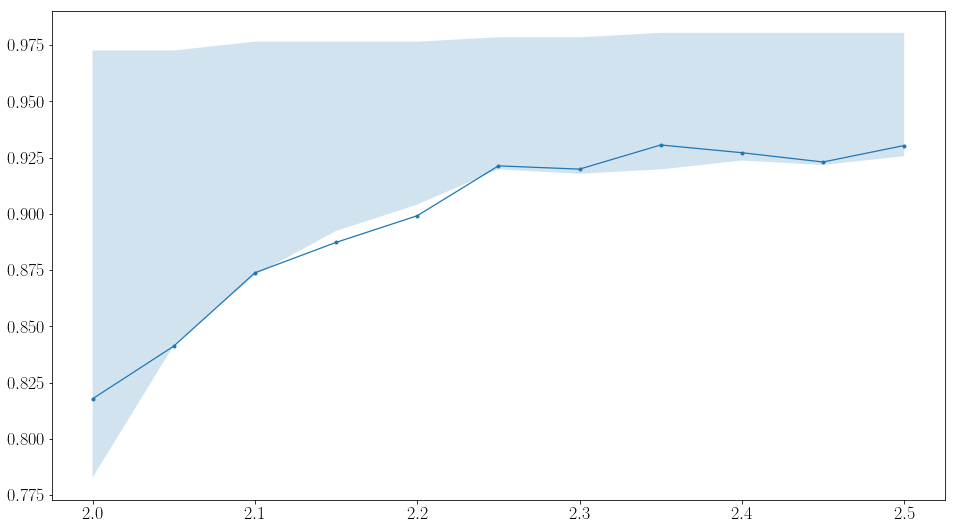

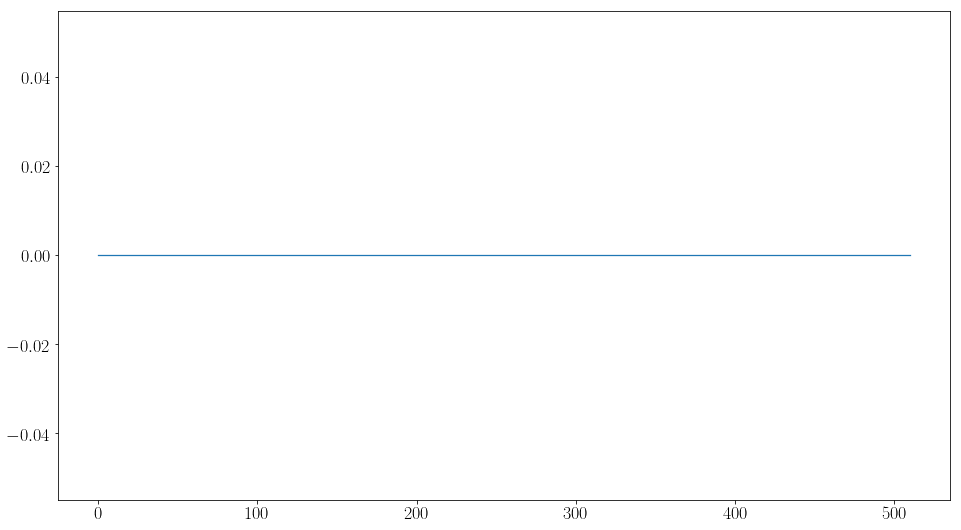

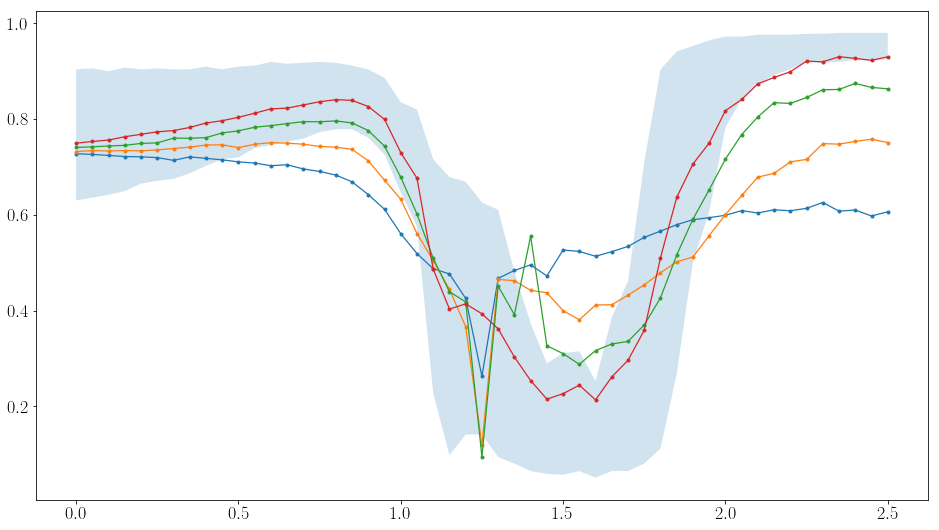

In [211]:
i = -1
plt.figure()
plt.plot(alpha[40:], max_centroid_wnorm[i, 40:] / deg_of_freedom[i], '.-')
plt.fill_between(alpha[40:], quartile[0, i, 40:] / deg_of_freedom[i], quartile[1, i, 40:] / deg_of_freedom[i], alpha = 0.2)

plt.figure()
plt.plot(cum_zdata[:, 0, -8])

plt.figure()
for i in range(len(N)):
    plt.plot(alpha, max_centroid_wnorm[i, :] / deg_of_freedom[i], '.-')
    


np.sum(compute_cumulative(zdata_wnorm[:, 0]) < 0.25)

In [163]:
2.5 / 250

0.01

In [39]:
# max_centroid_wnorm[-1, 7] = (max_centroid_wnorm[-1, 8] + max_centroid_wnorm[-1, 6]) / 2 
# pos_centroid_wnorm[-1, 7] = (pos_centroid_wnorm[-1, 8] + pos_centroid_wnorm[-1, 6]) / 2 

# max_entropy_wnorm[-1, 7] = (max_entropy_wnorm[i, 8] + max_entropy_wnorm[i, 6]) / 2

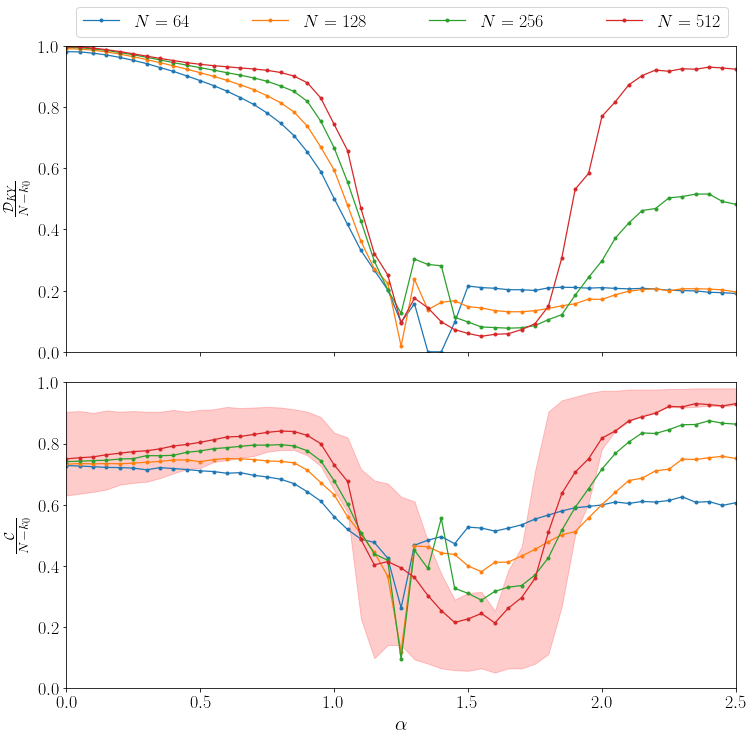

In [213]:
fig = plt.figure(figsize = (12, 18), tight_layout = False)
gs  = GridSpec(3, 1, hspace = 0.1 )

mpl.rcParams['font.size'] = 18
xlabel_size = 20
ylabel_size = 20

ax1 = fig.add_subplot(gs[0, 0])
for i in range(len(N)):
    plt.plot(alpha[:], kaplan_york_dim[i, :] / deg_of_freedom[i], '.-')
ax1.set_xlim(alpha[0], alpha[-1])
ax1.set_ylim(0, 1)
# ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.set_ylabel(r"$\frac{\mathcal{D}_{KY}}{ N - k_0}$", fontsize = ylabel_size)

ax2 = fig.add_subplot(gs[1, 0])
for i in range(len(N)):
    ax2.plot(alpha, max_centroid_wnorm[i, :] / deg_of_freedom[i], '.-')
    if i == len(N) - 1:
        plt.fill_between(alpha, quartile[0, i, :] / deg_of_freedom[i], quartile[1, i, :] / deg_of_freedom[i], alpha = 0.2, color = 'red')
#     ax2.plot(alpha, pos_centroid_wnorm[i, :] / deg_of_freedom[i], '.-')
ax2.set_xlim(alpha[0], alpha[-1])
ax2.set_ylim(0, 1)
# ax2.set_xticks([])
# ax2.set_xticklabels([])
ax2.set_ylabel(r"$\frac{\overbar{K}{N - k_0}$", fontsize = ylabel_size)
ax2.set_xlabel(r"$\alpha$", fontsize = xlabel_size)
ax2.set_xlim(alpha[0], alpha[-1])

# ax3 = fig.add_subplot(gs[2, 0])
# for i in range(len(N)):
#     ax3.plot(alpha, max_entropy_wnorm[i, :] / np.log(deg_of_freedom[i]), '.-')
# ax3.set_ylim(0.65, 1)
# ax3.set_ylabel(r"$\mathcal{H} / \mathcal{H}_{max}$", fontsize = ylabel_size)


ax1.legend([r"$N = {}$".format(int(n / 2)) for n in N], bbox_to_anchor = (0.001, 1.0, 1, 0.2), loc="lower left", mode = "expand", ncol = len(N))

plt.savefig(output_dir + "/PAPER_WNORM_ALPHA[VARIED]_BETA[{:0.3f}]_k0[{}]_ITERS[{}]_u0[{}].pdf".format(beta, k0, iters, u0), bbox_inches='tight') 
# plt.savefig(output_dir + "/PAPER_WNORM_CHAOTIC_ALPHA[VARIED]_BETA[{:0.3f}]_k0[{}]_ITERS[{}]_u0[{}].pdf".format(beta, k0, iters, u0), bbox_inches='tight') 

/home/ecarroll/ecpy/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


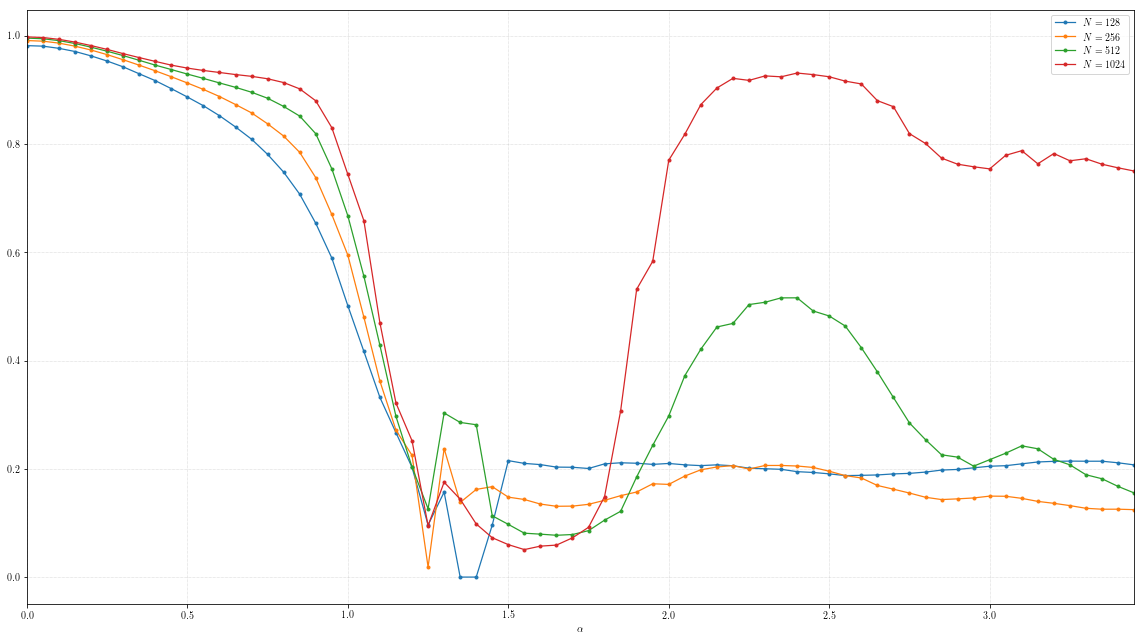

In [8]:
# Kaplan-Yorke Dimension / DOF 
fig = plt.figure(figsize = (16, 9), tight_layout = True)
gs  = GridSpec(1, 3)
for i in range(len(N)):
    plt.plot(alpha[:], kaplan_york_dim[i, :] / deg_of_freedom[i], '.-')
plt.xlim(alpha[0], alpha[-1])
plt.yscale('linear')
plt.grid(which = 'both', linestyle=':', linewidth='0.5', axis = 'both')
plt.xlabel(r"$\alpha$")
plt.legend([r"$N = {val}$".format(val = nn) for nn in N])
plt.savefig(output_dir + "/KAPLANYORKE_DEGOFFREE_ALPHA[VARIED]_BETA[{:0.3f}]_k0[{}]_ITERS[{}]_u0[{}].pdf".format(beta, k0, iters, u0)) 
plt.show()

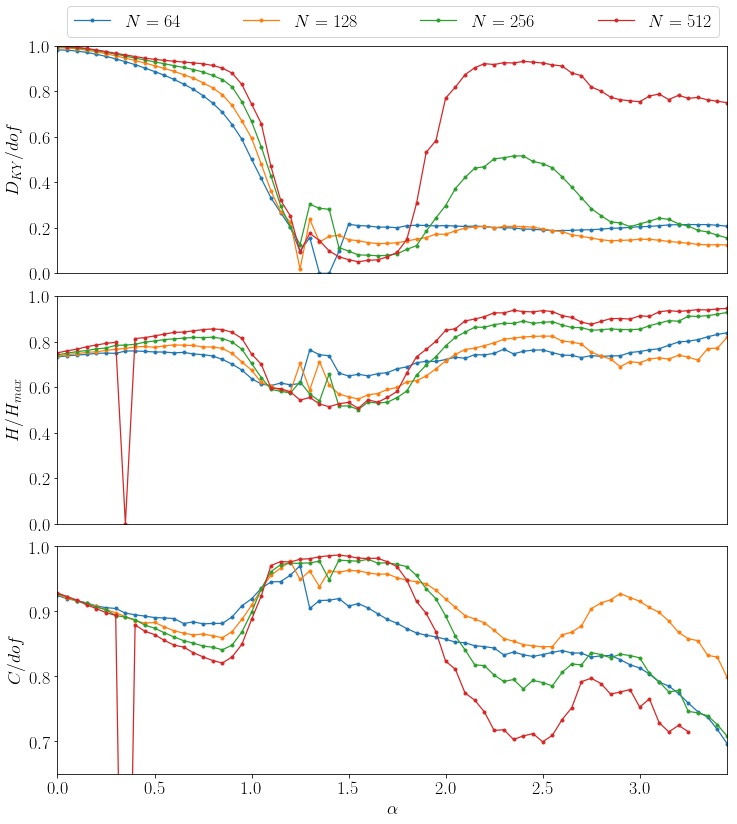

In [43]:
fig = plt.figure(figsize = (12, 18), tight_layout = False)
gs  = GridSpec(4, 1, hspace = 0.1 )



ax1 = fig.add_subplot(gs[0, 0])
for i in range(len(N)):
    plt.plot(alpha[:], kaplan_york_dim[i, :] / deg_of_freedom[i], '.-')
ax1.set_xlim(alpha[0], alpha[-1])
ax1.set_ylim(0, 1)
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.set_ylabel(r"$D_{KY} / dof$")

ax2 = fig.add_subplot(gs[1, 0])
for i in range(len(N)):
    ax2.plot(alpha, max_centroid[i, :] / deg_of_freedom[i], '.-')
ax2.set_xlim(alpha[0], alpha[-1])
ax2.set_ylim(0, 1)
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.set_ylabel(r"$H / H_{max}$")

ax3 = fig.add_subplot(gs[2, 0])
for i in range(len(N)):
    ax3.plot(alpha, max_entropy[i, :] / np.log(deg_of_freedom[i]), '.-')
ax3.set_xlabel(r"$\alpha$")
ax3.set_xlim(alpha[0], alpha[-1])
ax3.set_ylim(0.65, 1)
ax3.set_ylabel(r"$C / dof$")

ax1.legend([r"$N = {}$".format(int(n / 2)) for n in N], bbox_to_anchor = (0.001, 1.0, 1, 0.2), loc="lower left", mode = "expand", ncol = len(N))

plt.savefig(output_dir + "/PAPER_ALPHA[VARIED]_BETA[{:0.3f}]_k0[{}]_ITERS[{}]_u0[{}].pdf".format(beta, k0, iters, u0), bbox_inches='tight') 

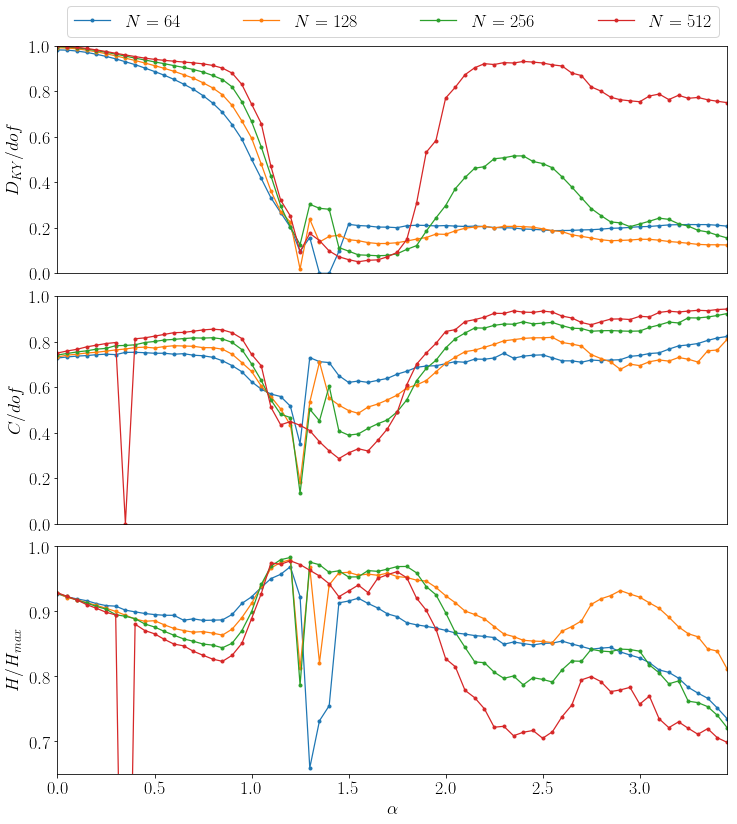

In [45]:
fig = plt.figure(figsize = (12, 18), tight_layout = False)
gs  = GridSpec(4, 1, hspace = 0.1 )



ax1 = fig.add_subplot(gs[0, 0])
for i in range(len(N)):
    plt.plot(alpha[:], kaplan_york_dim[i, :] / deg_of_freedom[i], '.-')
ax1.set_xlim(alpha[0], alpha[-1])
ax1.set_ylim(0, 1)
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.set_ylabel(r"$D_{KY} / dof$")

ax2 = fig.add_subplot(gs[1, 0])
for i in range(len(N)):
    ax2.plot(alpha, max_centroid_proj[i, :] / deg_of_freedom[i], '.-')
ax2.set_xlim(alpha[0], alpha[-1])
ax2.set_ylim(0, 1)
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.set_ylabel(r"$C / dof$")


ax3 = fig.add_subplot(gs[2, 0])
for i in range(len(N)):
    ax3.plot(alpha, max_entropy_proj[i, :] / np.log(deg_of_freedom[i]), '.-')
ax3.set_xlabel(r"$\alpha$")
ax3.set_xlim(alpha[0], alpha[-1])
ax3.set_ylim(0.65, 1)
ax3.set_ylabel(r"$H / H_{max}$")

ax1.legend([r"$N = {}$".format(int(n / 2)) for n in N], bbox_to_anchor = (0.001, 1.0, 1, 0.2), loc="lower left", mode = "expand", ncol = len(N))

plt.savefig(output_dir + "/PAPER_PROJ_ALPHA[VARIED]_BETA[{:0.3f}]_k0[{}]_ITERS[{}]_u0[{}].pdf".format(beta, k0, iters, u0), bbox_inches='tight') 

In [5]:
## ------ Parameters
N     = [128, 256, 512, 1024]
alpha = np.arange(0.0, 2.55, 0.05)
k0    = 1
beta  = 0.0
iters = 400000
m_end = 8000
m_itr = 50
trans = 0
u0    = "RANDOM"


## ------ Input and Output Dirs
input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/Paper"
output_dir = input_dir

## ------ Open Data File
PaperData = h5py.File(input_dir + "/PaperData.hdf5", "r")

## ------ Read in Data
quartile         = PaperData['Quartiles'][:, :]
deg_of_freedom   = PaperData['DOF'][:]
kaplan_york_dim  = PaperData['KaplanYorke'][:, :]
max_mean_k_enorm = PaperData['MaxMeankENorm'][:, :]


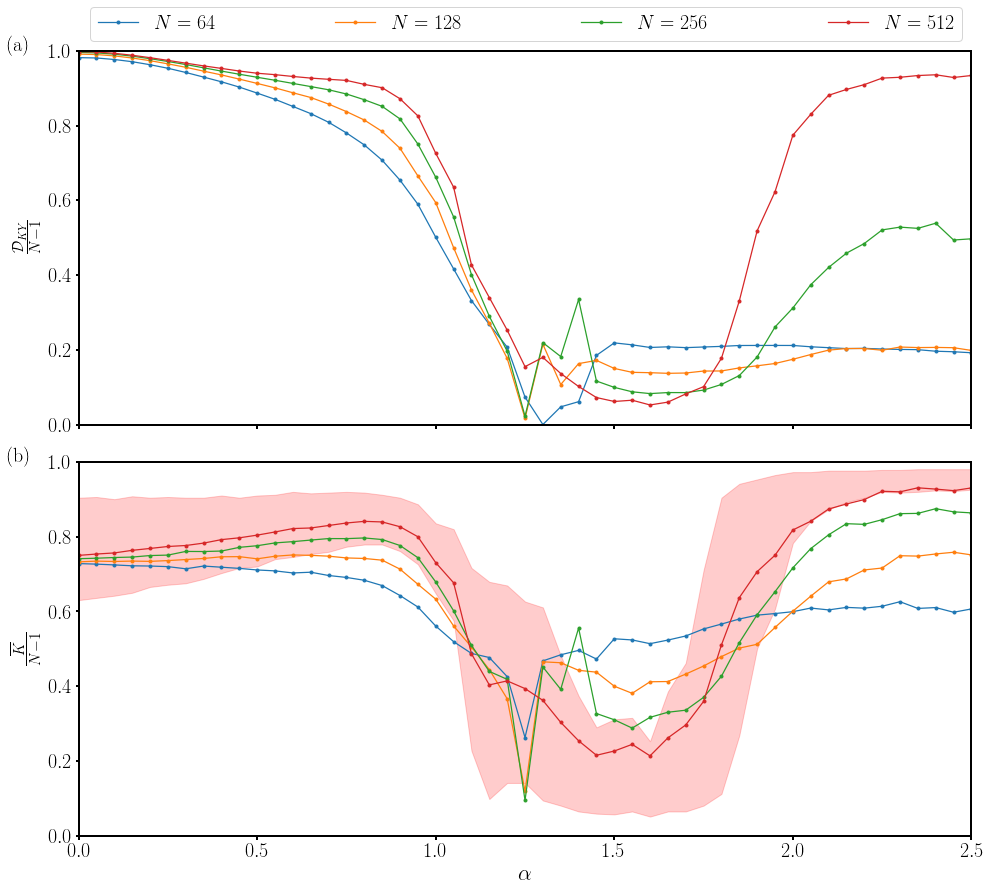

In [21]:
## ------ Plot Data
fig = plt.figure(figsize = (16, 22), tight_layout = False)
gs  = GridSpec(3, 1, hspace = 0.1)

mpl.rcParams['font.size'] = 20
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['axes.linewidth']    = 2
xlabel_size = 22
ylabel_size = 22

ax1 = fig.add_subplot(gs[0, 0])
for i in range(len(N)):
    plt.plot(alpha[:], kaplan_york_dim[i, :] / deg_of_freedom[i], '.-')
ax1.set_xlim(alpha[0], alpha[-1])
ax1.set_ylim(0, 1)
ax1.set_xticklabels([])
ax1.set_ylabel(r"$\frac{\mathcal{D}_{KY}}{ N - 1}$", fontsize = ylabel_size)

ax2 = fig.add_subplot(gs[1, 0])
for i in range(len(N)):
    ax2.plot(alpha, max_mean_k_enorm[i, :] / deg_of_freedom[i], '.-')
    if i == len(N) - 1:
        plt.fill_between(alpha, quartile[0, i, :] / deg_of_freedom[i], quartile[1, i, :] / deg_of_freedom[i], alpha = 0.2, color = 'red')
ax2.set_xlim(alpha[0], alpha[-1])
ax2.set_ylim(0, 1)
ax2.set_ylabel(r"$\frac{\overline{K}}{N - 1}$", fontsize = ylabel_size)
ax2.set_xlabel(r"$\alpha$", fontsize = xlabel_size)
ax2.set_xlim(alpha[0], alpha[-1])

ax1.text(-0.2, 1, r"(a)", fontweight = 'bold')
ax2.text(-0.2, 1, r"(b)")
ax1.legend([r"$N = {}$".format(int(n / 2)) for n in N], bbox_to_anchor = (0.001, 1.0, 1, 0.2), loc="lower left", mode = "expand", ncol = len(N))

plt.show()